In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from matplotlib import cm
from matplotlib.lines import Line2D
import matplotlib.lines as mlines

import time
from numpy.random import default_rng

import healpy as hp
from healpy.newvisufunc import projview, newprojplot
import pandas as pd

import astropy.cosmology
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table, join

import sys
sys.path.insert(0,'../code')
%load_ext autoreload
%autoreload 2
import utils
import generate_random
import correlations
import masks
import maps
import animate

# Parameter setting

Plot formatting

In [2]:
matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['axes.labelsize'] = 22
matplotlib.rcParams['axes.titlesize'] = 24
matplotlib.rcParams['legend.fontsize'] = 18

matplotlib.rc('text', usetex=True)

Saving

In [3]:
plot_dir = '../plots/2023-04-04_figures'
save = True

Names

In [4]:
name_catalog = 'Quasars with unWISE and \emph{{Gaia}} Catalog'
abbrv_catalog = 'QUaia'

name_gpurer = "\emph{{Gaia}} DR3 Quasars 'Purer' Sample"
abbrv_gpurer = "\emph{{Gaia}} DR3 'Purer'"

name_gall = "\emph{{Gaia}} DR3 Quasar Candidates"
abbrv_gall = "\emph{{Gaia}} DR3 Quasar Candidates"

name_sqall = "SDSS DR16Q Quasars"
abbrv_sqall = "SDSS DR16Q Quasars"

Plotting variables

In [5]:
cmap_anim = utils.shiftedColorMap(matplotlib.cm.plasma_r, start=0.2, midpoint=0.6, stop=1.0)
cmap_map = 'plasma'
cmap_blues = utils.shiftedColorMap(matplotlib.cm.Blues, start=0.2, midpoint=0.6, stop=1.0)
cmap_hist = utils.shiftedColorMap(matplotlib.cm.inferno_r, start=0.1, midpoint=0.55, stop=1.0)

color_gaia = 'purple'

Functions

In [6]:
def get_ndens_map(ras, decs, NSIDE=64):
    map_nqso, _ = maps.get_map(NSIDE, ras, decs, null_val=0)
    map_ndens = map_nqso/area_per_pixel
    map_ndens_masked = hp.ma(map_ndens)
    map_ndens_masked.mask = map_ndens==0
    return map_ndens_masked

Map settings

In [7]:
NSIDE = 64
area_per_pixel = hp.nside2pixarea(NSIDE, degrees=True)
print(f"Area per pixel: {area_per_pixel:.3f} deg")

Area per pixel: 0.839 deg


Other prelims

In [8]:
G_hi = 20.5
G_lo = 20.0

In [9]:
rng = np.random.default_rng(seed=42)

# Load datasets

### Gaia

In [10]:
fn_gall = '../data/gaia_candidates_plus.fits.gz'
tab_gall = utils.load_table(fn_gall)
print(len(tab_gall))

6649162


In [11]:
fn_gpurer_ids = '../data/gaia_purer_sourceids.fits'
tab_gpurer_ids = utils.load_table(fn_gpurer_ids)
tab_gpurer = join(tab_gall, tab_gpurer_ids, keys='source_id', join_type='inner', metadata_conflicts='silent')
print(len(tab_gpurer))

1942825


In [12]:
fn_gsup = '../data/gaia_candidates_superset.fits'
tab_gsup = utils.load_table(fn_gsup)
print(len(tab_gsup))

1518782


In [13]:
fn_gclean = '../data/gaia_candidates_clean.fits'
tab_gclean = utils.load_table(fn_gclean)
print(len(tab_gclean))

1414385


In [14]:
fn_gcatlo = f'../data/catalog_G{G_lo}.fits'
tab_gcatlo = utils.load_table(fn_gcatlo)
print(len(tab_gcatlo))

755850


In [15]:
fn_gcathi = f'../data/catalog_G{G_hi}.fits'
tab_gcathi = utils.load_table(fn_gcathi)
print(len(tab_gcathi))

1295502


### SDSS

These are SDSS objects that have (any) Gaia source matches. There is unWISE data where available, but the below catalogs are not limited to unWISE matches.

In [16]:
tab_squasars = utils.load_table(f'../data/quasars_sdss_xgaia_xunwise_good_nodup.fits')
print(f"Number of SDSS quasars: {len(tab_squasars)}")

Number of SDSS quasars: 379698


In [17]:
tab_sstars = utils.load_table(f'../data/stars_sdss_xgaia_xunwise_good_nodup.fits')
print(f"Number of SDSS stars: {len(tab_sstars)}")

Number of SDSS stars: 683221


In [18]:
tab_sgals = utils.load_table(f'../data/galaxies_sdss_xgaia_xunwise_good_nodup.fits')
print(f"Number of SDSS galaxies: {len(tab_sgals)}")

Number of SDSS galaxies: 717059


SDSS quasars with zwarning=0; gaia and unWISE data where available

In [19]:
tab_sqall = utils.load_table(f'../data/quasars_sdss_xgaiaall_xunwiseall_good.fits')
print(f"Number of all SDSS quasars: {len(tab_sqall)}")

Number of all SDSS quasars: 638083


### Other contaminants

In [20]:
tab_mcs = utils.load_table(f'../data/mcs_xgaia.fits')
print(f"Number of MC sources: {len(tab_mcs)}")

Number of MC sources: 1362378


### Combined

Only objects in superset (gaia qso candidates with unWISE data and QSOC redshifts and G lim)

In [21]:
fn_labeled_sup = '../data/labeled_superset.fits'
tab_labeled_sup = utils.load_table(fn_labeled_sup)
print(f"Number of labeled Gaia quasar candidates for training/validation: {len(tab_labeled_sup)}")

Number of labeled Gaia quasar candidates for training/validation: 259641


### Gaia all map

In [22]:
map_gall = get_ndens_map(tab_gall['ra'], tab_gall['dec'], NSIDE=NSIDE)

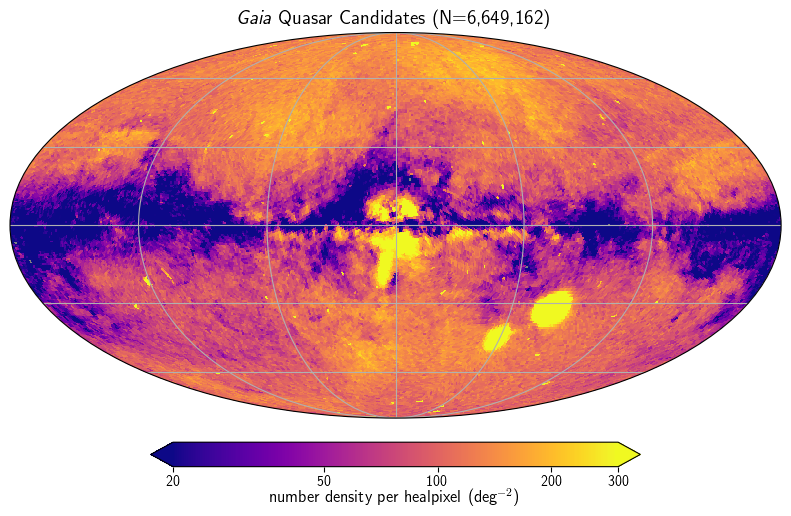

In [31]:
projview(map_gall, title=rf"\emph{{Gaia}} Quasar Candidates (N={len(tab_gall):,})",
            unit=r"number density per healpixel (deg$^{-2}$)", cmap=cmap_map, coord=['C', 'G'], 
            min=20, max=300, norm='log', graticule=True, 
           cbar_ticks=[20, 50, 100, 200, 300]
        )

## Decontamination

### Proper motions

Preliminaries

In [32]:
tabs_sall = [tab_squasars, tab_sstars, tab_sgals, tab_mcs]
colors_sall = ['blue', 'brown', 'orange', 'magenta']
labels_sall = ['SDSS Quasars', 'SDSS Stars', 'SDSS Galaxies', r'MCs $\times$ Gaia'+'\nQuasar Candidates']
#zorders_sall = [1,4,3,2]
zorders_sall = [1,3,4,2]

In [33]:
tab_pms = tab_gall.copy()
tab_pms.keep_columns(['source_id', 'pm'])

In [34]:
for i, tab in enumerate(tabs_sall):
    if 'pm' not in tab.columns:
        tabs_sall[i] = join(tab, tab_pms, keys='source_id', join_type='left')

In [35]:
tab_q = tab_labeled_sup[tab_labeled_sup['class']=='q']
tab_s = tab_labeled_sup[tab_labeled_sup['class']=='s']
tab_g = tab_labeled_sup[tab_labeled_sup['class']=='g']
tab_m = tab_labeled_sup[tab_labeled_sup['class']=='m']

tabs_ssup = [tab_s, tab_g, tab_m]
colors_ssup = ['brown', 'orange', 'magenta']
labels_ssup = [r'SDSS stars $\times$'+'\n'+f'{abbrv_catalog} superset', 
               r'SDSS galaxies $\times$'+'\n'+f'{abbrv_catalog} superset',
               r'LMC \& SMC stars $\times$'+'\n'+f'{abbrv_catalog} superset']
zorders_ssup = [3,2,1]

label_shist = rf'number of SDSS $\times$ {abbrv_catalog}'+'\nsuperset quasars'

In [36]:
label_ghist = rf'number of {abbrv_catalog}'+'\nsuperset quasars'

Proper motion vs G

In [48]:
def G_pm_plot(ax, fig, tabs_scatter=[], colors_scatter=[],
                 labels_scatter=[], zorders_scatter=[], N_subsample=None,
                 tab_hist=None, cmap_hist=None, label_hist=None, cmax_hist=None,
                 draw_cuts=True):

    ## histograms
    if tab_hist is not None:

        G = np.array(tab_hist['phot_g_mean_mag'])
        pm = np.array(tab_hist['pm'])
        h = ax.hist2d(G, pm, bins=(G_bins, pm_bins), cmin=1, cmax=cmax_hist, cmap=cmap_hist, norm='log')
        
        fig.colorbar(h[3], ax=ax, label=label_hist)

    # scatters        
    patches = []
    for i in range(len(tabs_scatter)):
        tab = tabs_scatter[i]
        tab_plot = tab
        if N_subsample is not None and len(tab_plot)>N_subsample:
            i_subsample = rng.choice(np.arange(len(tab)), size=N_subsample, replace=False)
            tab_plot = tab_plot[i_subsample]

        ax.scatter(tab_plot['phot_g_mean_mag'], 
                    tab_plot['pm'],
                    color=colors_scatter[i], alpha=0.15, s=0.7, zorder=zorders_scatter[i])
        
        patches.append( mlines.Line2D([], [], ls='None', color=colors_scatter[i], 
                                      label=labels_scatter[i], marker='o'))

    # draw cut
    if draw_cuts:
        yy = utils._pm_G_line(G_bins)
        ax.plot(G_bins, yy, color='black')
        yy_max = np.full(len(yy), pm_bins[-1])
        ax.fill_between(G_bins, yy, yy_max, color='grey', zorder=0, alpha=0.15)

    # plot settings
    if len(patches)>0:
        ax.legend(handles=patches, loc='upper left', fontsize=16)

    ax.set_xlabel('$G$ magnitude')
    ax.set_ylabel(r'$\mu$, proper motion [mas/yr]')
    ax.set_yscale('log')

    ax.set_xlim(G_bins[0], G_bins[-1])
    ax.set_ylim(pm_bins[0], pm_bins[-1])

In [38]:
xlim = 5, 20.6
bin_width = 0.2
G_bins = np.arange(xlim[0], xlim[1]+bin_width, bin_width)
pm_bins = np.logspace(np.log10(0.001), np.log10(300))

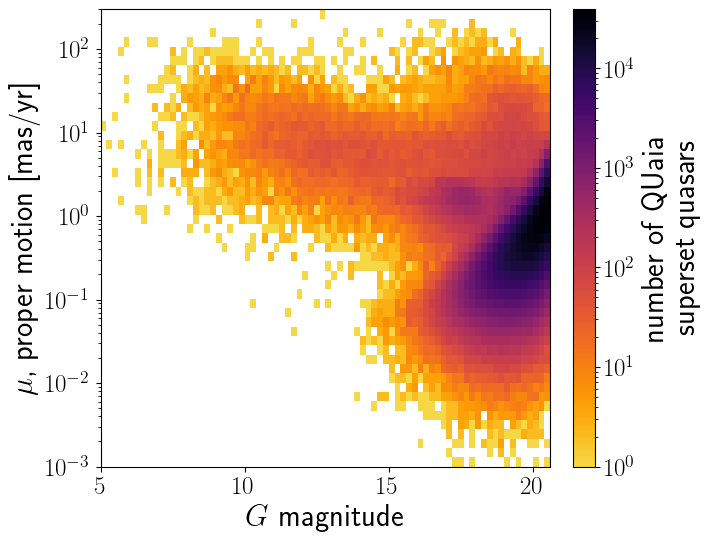

In [69]:
nrows = 1
fig, ax = plt.subplots(nrows=nrows, ncols=1, figsize=(7,5.3*nrows), constrained_layout=True)
title_x = 0.46

#fig.text(title_x, 1.03, abbrv_catalog+' superset', fontsize=22, va="center", ha="center")
G_pm_plot(ax, fig, tab_hist=tab_gsup, cmap_hist=cmap_hist, label_hist=label_ghist, cmax_hist=2e5, draw_cuts=False)

fig.get_layout_engine().set(hspace=0.1, wspace=0.05)

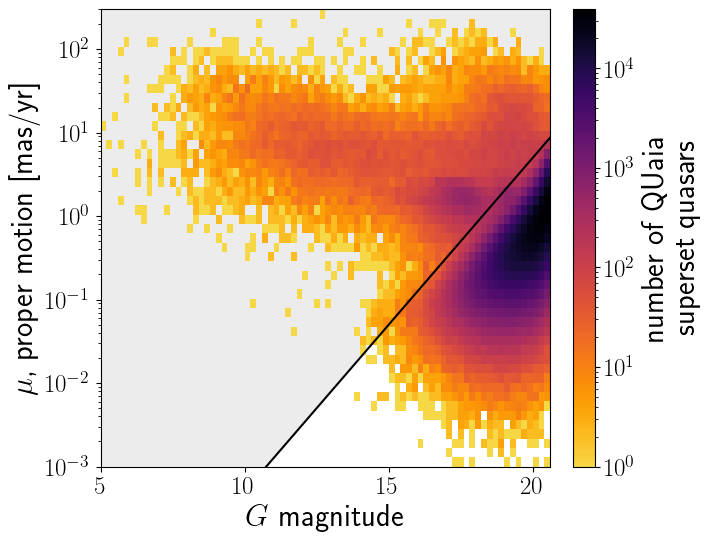

In [70]:
nrows = 1
fig, ax = plt.subplots(nrows=nrows, ncols=1, figsize=(7,5.3*nrows), constrained_layout=True)
title_x = 0.46

#fig.text(title_x, 1.03, abbrv_catalog+' superset', fontsize=22, va="center", ha="center")
G_pm_plot(ax, fig, tab_hist=tab_gsup, cmap_hist=cmap_hist, label_hist=label_ghist, cmax_hist=2e5)

fig.get_layout_engine().set(hspace=0.1, wspace=0.05)

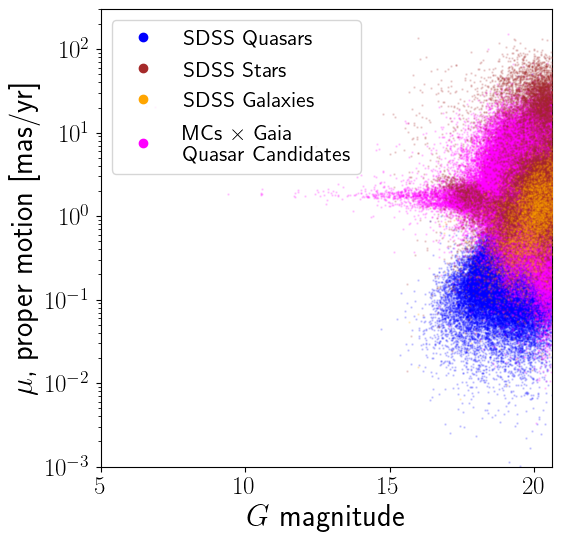

In [86]:
nrows = 1
fig, ax = plt.subplots(nrows=nrows, ncols=1, figsize=(5.5,5.3*nrows), constrained_layout=True)
title_x = 0.57

#fig.text(title_x, 1.02, "Labeled sources", fontsize=22, va="center", ha="center")
G_pm_plot(ax, fig, tabs_scatter=tabs_sall, colors_scatter=colors_sall, 
                     labels_scatter=labels_sall, zorders_scatter=zorders_sall, draw_cuts=False)
fig.get_layout_engine().set(hspace=0.1, wspace=0.05)

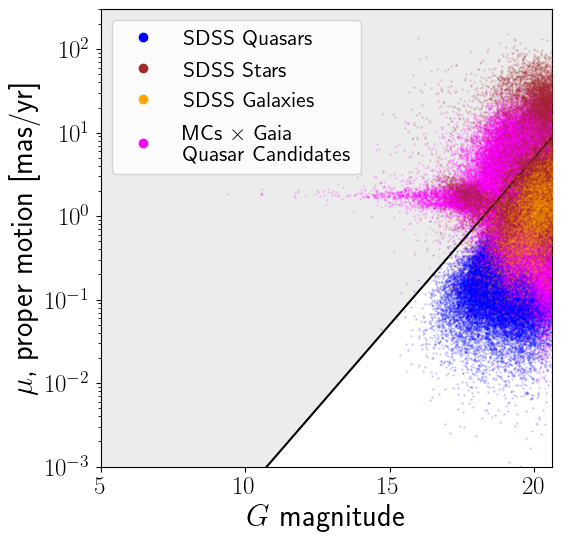

In [72]:
nrows = 1
fig, ax = plt.subplots(nrows=nrows, ncols=1, figsize=(5.5,5.3*nrows), constrained_layout=True)
title_x = 0.57

#fig.text(title_x, 1.02, "Labeled sources", fontsize=22, va="center", ha="center")
G_pm_plot(ax, fig, tabs_scatter=tabs_sall, colors_scatter=colors_sall, 
                     labels_scatter=labels_sall, zorders_scatter=zorders_sall)
fig.get_layout_engine().set(hspace=0.1, wspace=0.05)

## color-color

In [60]:
def plot_color_cuts(ax, cuts, cut_names, x_color_name, y_color_name, xlim, ylim,
              x_orders=None, y_orders=None, zorder=100):

    i_x, i_y = None, None
    if x_color_name in cut_names:
        i_x = cut_names.index(x_color_name)
    if y_color_name in cut_names:
        i_y = cut_names.index(y_color_name)
    
    color = 'k'
    cuts_toplot = []
    x_orders_toplot = []
    y_orders_toplot = []
    for i, cut_full in enumerate(cuts): 
        if i_x is None and i_y is None:
            continue
            
        intercept = cut_full[cut_names.index('intercept')]
        cut = [cut_full[i_x], cut_full[i_y], intercept]

        if i_y is None:
            cut[1] = 0
        if i_x is None:
            cut[0] = 0
        if cut[0]==0 and cut[1]==0:
            continue
            
        cuts_toplot.append(cut)
        x_orders_toplot.append(x_orders[i])
        y_orders_toplot.append(y_orders[i])
          
    xlims = [list(xlim) for _ in range(len(cuts_toplot))]
    ylims = [list(ylim) for _ in range(len(cuts_toplot))]

    # this is ugly but i think need some user input to determine order??
    for ix in range(len(x_orders_toplot)-1):
        i, j = x_orders_toplot.index(ix), x_orders_toplot.index(ix+1)
        cut_0, cut_1 = cuts_toplot[i], cuts_toplot[j]
        x_eq = (cut_0[2]*cut_1[1] - cut_1[2]*cut_0[1])/(cut_0[0]*cut_1[1] - cut_1[0]*cut_0[1])
        xlims[i][1] = x_eq
        xlims[j][0] = x_eq

    for iy in range(len(y_orders_toplot)-1):
        i, j = y_orders_toplot.index(iy), y_orders_toplot.index(iy+1)
        cut_0, cut_1 = cuts_toplot[i], cuts_toplot[j]
        y_eq = (cut_0[2]*cut_1[0] - cut_1[2]*cut_0[0])/(cut_0[1]*cut_1[0] - cut_1[1]*cut_0[0])
        ylims[i][1] = y_eq
        ylims[j][0] = y_eq
        
    # not the most robust way to fill between but
    # fill between assumes exclude region is always *below*
    # and maybe assumes other things idk
    xx_fill = []
    yy_fill_max = []
    lw = 1
    alpha = 1
    color = 'k'
    for i, cut in enumerate(cuts_toplot):
        xx = np.array(xlims[i])
        yy = np.array(ylims[i])
    
        tol = 1e-8
        
        if abs(cut[0])<tol:
            ax.hlines(cut[2], xmin=xx[0], xmax=xx[1], color=color, lw=lw, zorder=zorder, alpha=alpha)
            xx_fill.extend(xx)
            yy_fill_max.extend([cut[2], cut[2]])
        elif abs(cut[1])<tol:
            ax.vlines(cut[2], *yy, color=color, lw=lw, zorder=zorder, alpha=alpha)
            xx_fill.extend([xlim[0], cut[2]])
            yy_fill_max.extend([ylim[1], ylim[1]])
        else:
            xcut = (cut[2] - cut[1]*yy)/cut[0]
            ax.plot(xcut, yy, color=color, lw=lw, zorder=zorder, alpha=alpha)
            xx_fill.extend(xcut)
            yy_fill_max.extend(yy)
    
    xx_fill = np.array(xx_fill)
    yy_fill_min = np.full(len(yy_fill_max), ylim[0])
    yy_fill_max = np.array(yy_fill_max)

    i_sort = np.argsort(xx_fill)
    xx_fill = xx_fill[i_sort]
    yy_fill_min = yy_fill_min[i_sort]
    yy_fill_max = yy_fill_max[i_sort]

    ax.fill_between(xx_fill, yy_fill_min, yy_fill_max, color='grey', zorder=0, alpha=0.15)


In [61]:
tag_decontam = '_mag0.1_lm5_postpm'
fn_cuts = f'../data/color_cuts{tag_decontam}.txt'
cuts = np.genfromtxt(fn_cuts, delimiter=',', names=True)
cut_names = cuts.dtype.names

In [62]:
g_w1_lim = (-1, 9)
w1_w2_lim = (-1, 2)
bp_g_lim = (-4, 3)
g_rp_lim = (-1, 6)

bins_g_w1 = np.linspace(*g_w1_lim, 100)
bins_w1_w2 = np.linspace(*w1_w2_lim, 100)

bins_bp_g = np.linspace(*bp_g_lim, 100)
bins_g_rp = np.linspace(*g_rp_lim, 100)

In [65]:
def color_color_plot_row(ax0, ax1, fig, tabs_scatter=[], colors_scatter=[],
                         labels_scatter=[], zorders_scatter=[], N_subsample=None,
                         tab_hist=None, cmap_hist=None, label_hist=None, cmax_hist=None,
                         draw_cuts=True):

    ## histograms
    if tab_hist is not None:

        g_w1 = np.array(tab_hist['phot_g_mean_mag']-tab_hist['mag_w1_vg'])
        w1_w2 = np.array(tab_hist['mag_w1_vg']-tab_hist['mag_w2_vg'])
        h = ax0.hist2d(g_w1, w1_w2, bins=(bins_g_w1, bins_w1_w2), cmin=1, cmax=cmax_hist, cmap=cmap_hist, norm='log')

        bp_g = np.array(tab_hist['phot_bp_mean_mag']-tab_hist['phot_g_mean_mag'])
        g_rp = np.array(tab_hist['phot_g_mean_mag']-tab_hist['phot_rp_mean_mag'])
        h = ax1.hist2d(bp_g, g_rp, bins=(bins_bp_g, bins_g_rp), cmin=1, cmax=cmax_hist, cmap=cmap_hist, norm='log')

        fig.colorbar(h[3], ax=[ax0, ax1], label=label_hist)

    # scatters        
    patches = []
    for i in range(len(tabs_scatter)):
        tab = tabs_scatter[i]
        i_unwise = np.isfinite(tab['mag_w1_vg']) & ~tab.mask['mag_w1_vg'] & \
                   np.isfinite(tab['mag_w2_vg']) & ~tab.mask['mag_w2_vg']
        tab_plot = tab[i_unwise]
        if N_subsample is not None and np.sum(i_unwise)>N_subsample:
            i_subsample = rng.choice(np.arange(len(tab[i_unwise])), size=N_subsample, replace=False)
            tab_plot = tab_plot[i_subsample]

        ax0.scatter(tab_plot['phot_g_mean_mag']-tab_plot['mag_w1_vg'], 
                    tab_plot['mag_w1_vg']-tab_plot['mag_w2_vg'],
                    color=colors_scatter[i], alpha=0.15, s=0.7, zorder=zorders_scatter[i])

        ax1.scatter(tab_plot['phot_bp_mean_mag']-tab_plot['phot_g_mean_mag'], 
                    tab_plot['phot_g_mean_mag']-tab_plot['phot_rp_mean_mag'],
                    color=colors_scatter[i], alpha=0.15, s=0.7, zorder=zorders_scatter[i])

        patches.append( mlines.Line2D([], [], ls='None', color=colors_scatter[i], 
                                      label=labels_scatter[i], marker='o'))

    # draw cuts
    if draw_cuts:
        plot_color_cuts(ax0, cuts, cut_names, x_color_name='g_w1', y_color_name='w1_w2', xlim=g_w1_lim, ylim=w1_w2_lim,
                 x_orders=[0, 2, None, 1], y_orders=[2, 0, None, 1], zorder=4)
        plot_color_cuts(ax1, cuts, cut_names, x_color_name='bp_g', y_color_name='g_rp', xlim=bp_g_lim, ylim=g_rp_lim,
                  x_orders=[None, None, 0, None], y_orders=[None, None, 0, None], zorder=4)

    # plot settings
    if len(patches)>0:
        ax1.legend(handles=patches, loc='upper right', fontsize=16)

    ax0.set_xlabel(r'$G-W1$')
    ax0.set_ylabel(r'$W1-W2$')
    ax0.set_xlim(g_w1_lim)
    ax0.set_ylim(w1_w2_lim)

    ax1.set_xlabel(r'$BP-G$')
    ax1.set_ylabel(r'$G-RP$')
    ax1.set_xlim(bp_g_lim)
    ax1.set_ylim(g_rp_lim)

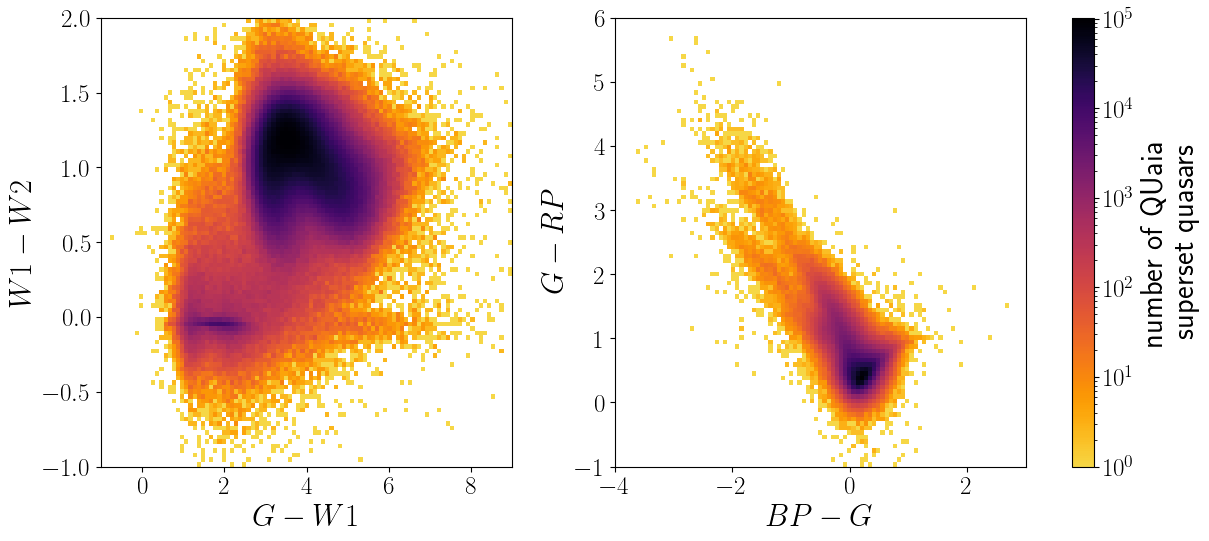

In [73]:
nrows = 1
fig, axarr = plt.subplots(nrows=nrows, ncols=2, figsize=(12,5.3*nrows), constrained_layout=True)
title_x = 0.46

#fig.text(title_x, 1.03, abbrv_catalog+' superset', fontsize=22, va="center", ha="center")
color_color_plot_row(axarr[0], axarr[1], fig, tab_hist=tab_gsup, cmap_hist=cmap_hist, label_hist=label_ghist, cmax_hist=2e5, 
                     draw_cuts=False)

fig.get_layout_engine().set(hspace=0.1, wspace=0.05)

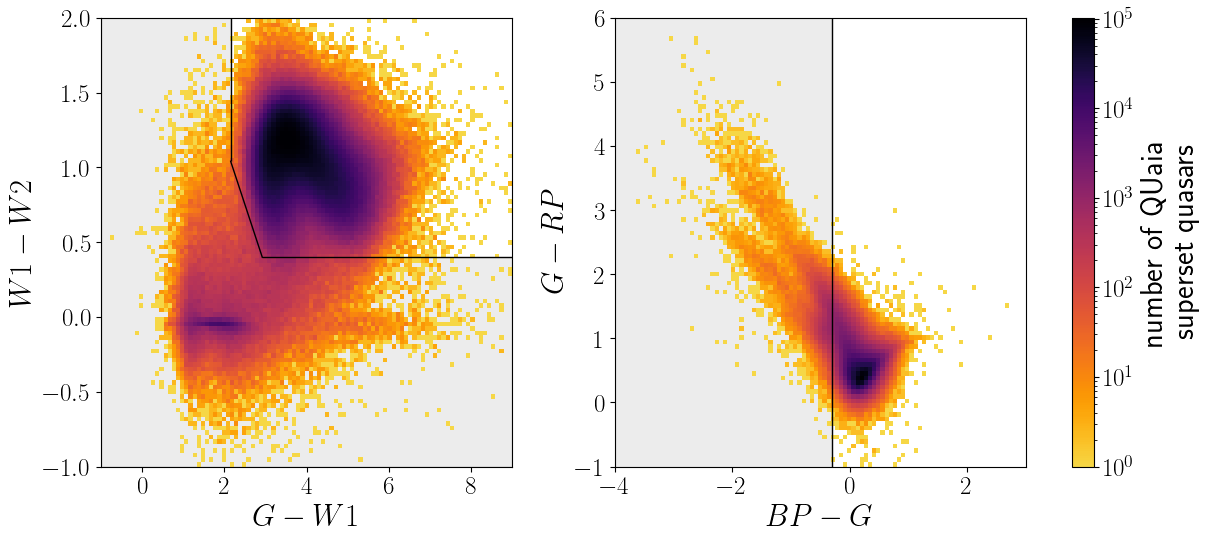

In [74]:
nrows = 1
fig, axarr = plt.subplots(nrows=nrows, ncols=2, figsize=(12,5.3*nrows), constrained_layout=True)
title_x = 0.46

#fig.text(title_x, 1.03, abbrv_catalog+' superset', fontsize=22, va="center", ha="center")
color_color_plot_row(axarr[0], axarr[1], fig, tab_hist=tab_gsup, cmap_hist=cmap_hist, label_hist=label_ghist, cmax_hist=2e5, 
                     draw_cuts=True)

fig.get_layout_engine().set(hspace=0.1, wspace=0.05)

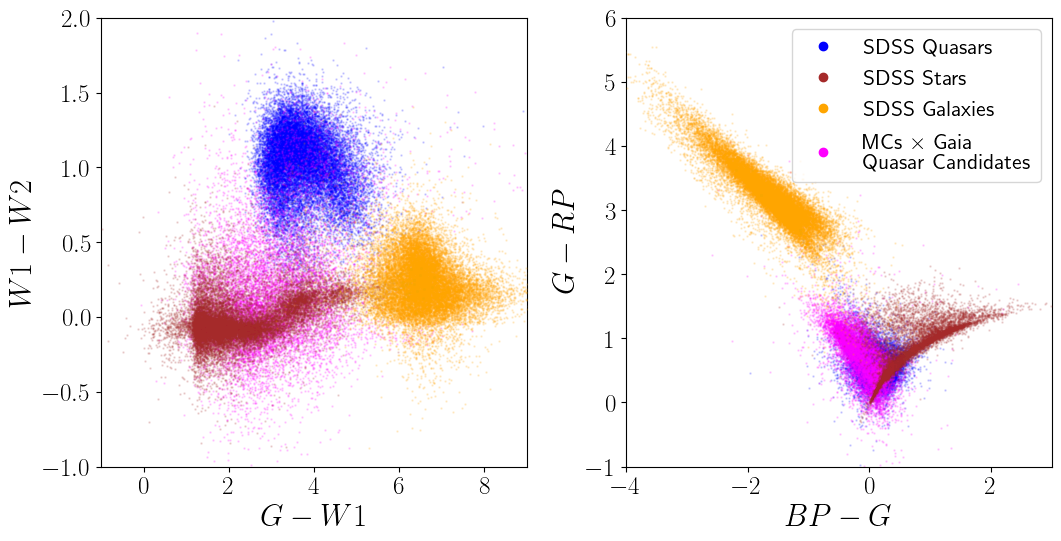

In [88]:
nrows = 1
fig, axarr = plt.subplots(nrows=nrows, ncols=2, figsize=(10.5,5.3*nrows), constrained_layout=True)
title_x = 0.57

#fig.text(title_x, 1.02, "Labeled sources", fontsize=22, va="center", ha="center")
color_color_plot_row(axarr[0], axarr[1], fig, tabs_scatter=tabs_sall, colors_scatter=colors_sall, 
                     labels_scatter=labels_sall, zorders_scatter=zorders_sall, N_subsample=20000,
                     draw_cuts=False)
fig.get_layout_engine().set(hspace=0.1, wspace=0.05)

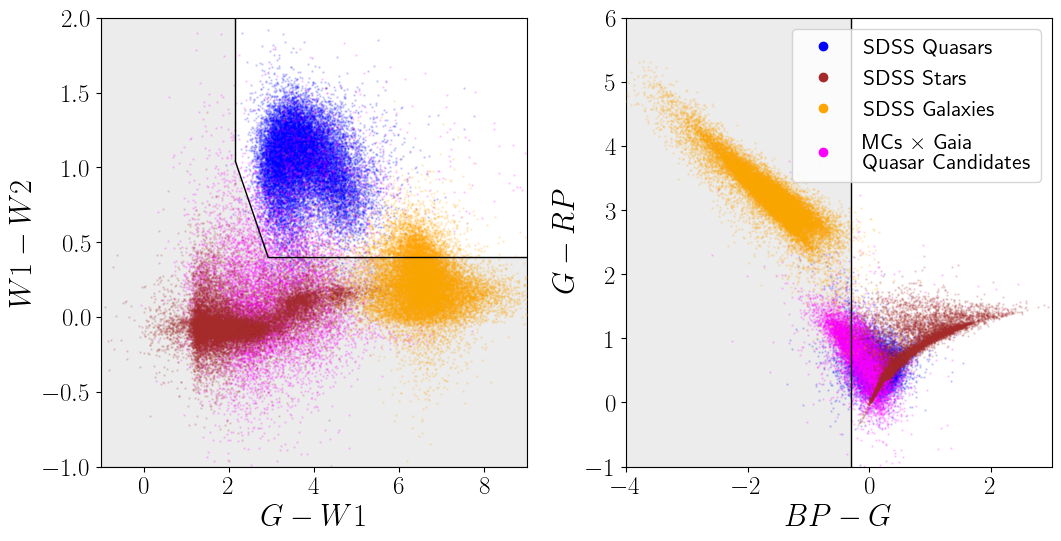

In [89]:
nrows = 1
fig, axarr = plt.subplots(nrows=nrows, ncols=2, figsize=(10.5,5.3*nrows), constrained_layout=True)
title_x = 0.57

#fig.text(title_x, 1.02, "Labeled sources", fontsize=22, va="center", ha="center")
color_color_plot_row(axarr[0], axarr[1], fig, tabs_scatter=tabs_sall, colors_scatter=colors_sall, 
                     labels_scatter=labels_sall, zorders_scatter=zorders_sall, N_subsample=20000,
                     draw_cuts=True)
fig.get_layout_engine().set(hspace=0.1, wspace=0.05)